In [1]:
import boto3
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import re, datetime
%matplotlib inline

pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [3]:
df_RC_bmo = pd.read_pickle("../Data/pickle_files/master_cleaneddf.pkl")

In [105]:
path = 's3://adl-core-sagemaker-studio/external/DSaaS/meijer_data_files/Meijer Listening 204 Calls with All Data.csv'
df_RC_meijer = pd.read_csv(path)

rc_cols = ['Universal ID for NICE','CCR Notes ','Topic Description', 'Subtopic Description', 
           'Root Cause \n(why did caller have to contact us to resolve issue? Select from drop down)']
cols = ['Universal_ID','cspro_notes','Cspro_Primary_Topic','Cspro_Primary_Subtopic','Root_Cause']

rc_meijer = df_RC_meijer.copy()[rc_cols].rename(columns={k:v for k,v in zip(rc_cols,cols)})
rc_meijer.dropna(how='all',inplace=True)

In [60]:
topic_cols = [x for x in df_RC_bmo.columns if 'topic' in x.lower()]
topic_cols.append('Root_Cause')
topic_cols.append('Right_call_unique_id')
rc_bmo = df_RC_bmo.copy()[topic_cols]
rc_bmo = rc_bmo.rename(columns={"Right_call_unique_id":"Universal_ID"})
rc_bmo.Universal_ID = rc_bmo.Universal_ID.fillna(99)

In [14]:
additional_cols_meijer = ['Primary Topic \n(what was domain of call about? Ex. Common, DC, DB, HW)',
 'Secondary Topic \n(what was call about? what the actual transaction was - ex. Phone Access; Upoint Access; rehire, pay change)\n',
 'Tertiary Topic\n(next level of what call was about - where were they having issues? - ex. Forgot Password, Reset Password; initiate a transaction, process a transaction, error in transaction)',
 'Secondary Root Cause\n( Select from drop down)']

In [10]:
rc_meijer.head(1)

,Universal_ID,cspro_notes,Cspro_Primary_Topic,Cspro_Primary_Subtopic,Root_Cause
0,381078596.0,ppt complete wellness check a pharmacy and rec...,HW - Benefit Options,Incentives and Surcharges,EE processing error/delay/inaction


In [11]:
rc_bmo.head(1)

,Cspro_Primary_Subtopic,Cspro_Primary_Topic,cspro_primary_topic_2,cspro_primary_subtopic_2,Root_Cause,Right_call_unique_id
0,Repayment Discussion,Payroll - Overpayment,Common,Secure Caller,Manager processing error/delay/inaction,3.56803e+08


In [61]:
rc_bmo.isna().sum().to_frame("BMO Null Count")

,BMO Null Count
Cspro_Primary_Subtopic,0
Cspro_Primary_Topic,0
cspro_primary_topic_2,104
cspro_primary_subtopic_2,104
Root_Cause,0
Universal_ID,0


In [58]:
rc_meijer.isna().sum().to_frame("Meijer Null Count")

,Meijer Null Count
Universal_ID,0
cspro_notes,35
Cspro_Primary_Topic,0
Cspro_Primary_Subtopic,0
Root_Cause,0


## Distribution of Root Causes

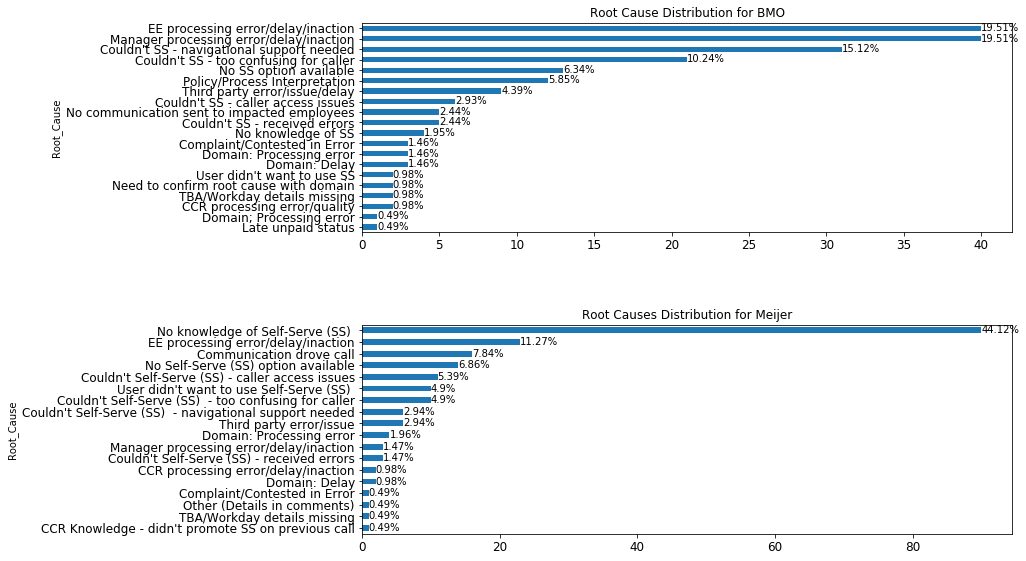

In [66]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.tight_layout(pad=2)

df_grp1 = (rc_bmo.groupby('Root_Cause')[['Universal_ID']].count().rename(columns={"Universal_ID":"Count"})
          .sort_values('Count',ascending=True))
df_grp2 = (rc_meijer.groupby('Root_Cause')[['Universal_ID']].count().rename(columns={"Universal_ID":"Count"})
          .sort_values('Count',ascending=True))

ax1 = df_grp1.plot.barh(ylim=0,ax=axes[0],figsize=(11,9),title="Root Cause Distribution for BMO",fontsize=12,legend=False)
ax2 = df_grp2.plot.barh(ylim=0,ax=axes[1],figsize=(11,9),title="Root Causes Distribution for Meijer",fontsize=12,legend=False)

for index,row in df_grp1.reset_index().iterrows():
    ax1.text(x=row["Count"], y=index-0.25, s=str(round((row["Count"]/df_grp1["Count"].sum())*100,2))+"%", fontsize=10)
for index,row in df_grp2.reset_index().iterrows():
    ax2.text(x=row["Count"], y=index-0.25, s=str(round((row["Count"]/df_grp2["Count"].sum())*100,2))+"%", fontsize=10)

plt.show()

In [154]:
set_bmo = pd.DataFrame(rc_bmo.Root_Cause.unique(),columns=["Root_Cause_BMO"])
set_meijer = pd.DataFrame(rc_meijer.Root_Cause.unique(),columns=["Root_Cause_Meijer"])
pd.merge(set_bmo,set_meijer,how="outer",left_on="Root_Cause_BMO",right_on="Root_Cause_Meijer").to_csv("RC_comaprison.csv",index=False)

## Finding associations between Primary Topic & Root Cause

In [110]:
def Association_df(rc_df,groupby_cols):
    # groupby for counts
    df1 = rc_df.groupby(groupby_cols,as_index=False)['Universal_ID'].count().rename(columns={'Universal_ID':"Topic_Count"})
    df2 = rc_df.groupby(groupby_cols+['Root_Cause'],as_index=False)['Universal_ID'].count().rename(columns={'Universal_ID':"Combination_Count"})
    #merge combinations with topics_list
    Topic_RC_df = df2.merge(df1,on=groupby_cols,copy=False)
    #calculate transactions
    n_transcations = Topic_RC_df.Combination_Count.sum()
    #calulate support
    Topic_RC_df = Topic_RC_df.assign(support_topic=(Topic_RC_df.Topic_Count/n_transcations)*100, 
                            support_combination=(Topic_RC_df.Combination_Count/n_transcations)*100)
    #calculate confidence
    Topic_RC_df["Confidence"] = (Topic_RC_df.support_combination/Topic_RC_df.support_topic)
    #combination
    return Topic_RC_df

In [111]:
bmo_topic_asc = Association_df(rc_bmo,groupby_cols=['Cspro_Primary_Topic'])
meijer_topic_asc = Association_df(rc_meijer,groupby_cols=['Cspro_Primary_Topic'])

bmo_topic_asc['Combination (Topic, Root_Cause)'] = bmo_topic_asc.apply(lambda x:(x.Cspro_Primary_Topic,x.Root_Cause), axis=1)
meijer_topic_asc['Combination (Topic, Root_Cause)'] = meijer_topic_asc.apply(lambda x:(x.Cspro_Primary_Topic,x.Root_Cause), axis=1)

				Displaying only Top 10 Most Frequent Topic-Root Cause Combinations


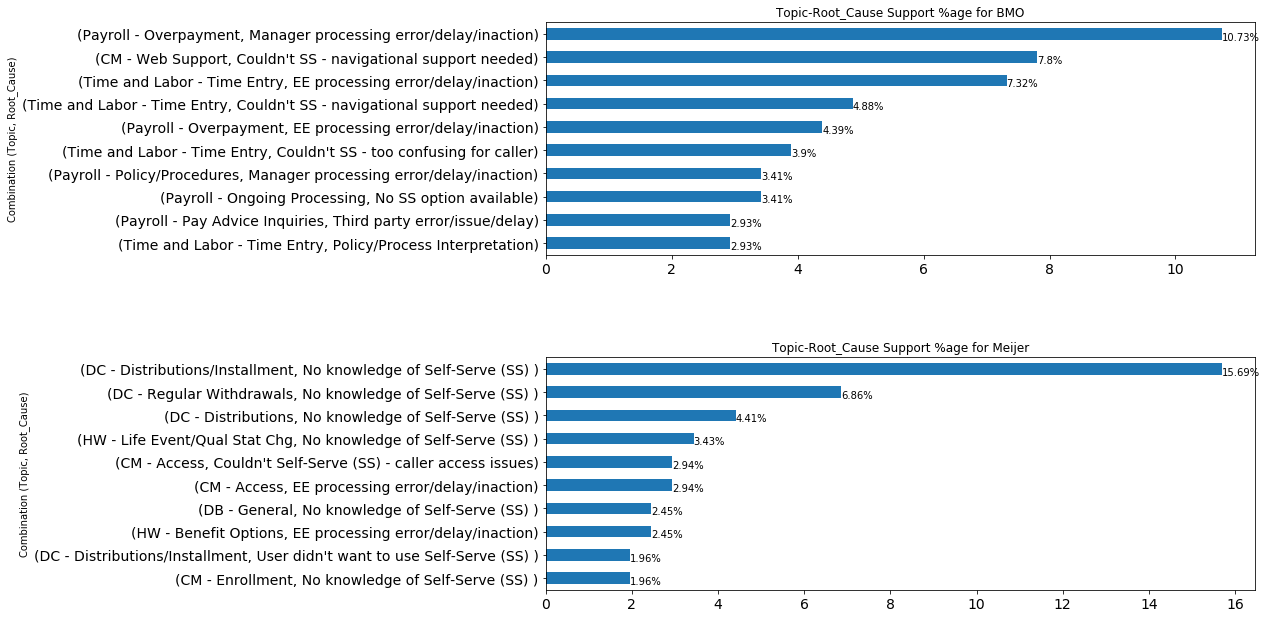

In [140]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.tight_layout(pad=2)
bmo_topic_asc.sort_values('support_combination',ascending=True,inplace=True)
meijer_topic_asc.sort_values('support_combination',ascending=True,inplace=True)
df_grp1 = bmo_topic_asc[['Combination (Topic, Root_Cause)','support_combination']].set_index('Combination (Topic, Root_Cause)').iloc[-10:]
df_grp2 = meijer_topic_asc[['Combination (Topic, Root_Cause)','support_combination']].set_index('Combination (Topic, Root_Cause)').iloc[-10:]

ax1 = df_grp1.plot.barh(ylim=0,ax=axes[0],figsize=(20,10),title="Topic-Root_Cause Support %age for BMO",fontsize=14,legend=False)
ax2 = df_grp2.plot.barh(ylim=0,ax=axes[1],figsize=(12,10),title="Topic-Root_Cause Support %age for Meijer",fontsize=14,legend=False)

for index,row in df_grp1.reset_index().iterrows():
    ax1.text(x=row["support_combination"], y=index-0.25, s=str(round(row["support_combination"],2))+"%", fontsize=10)

for index,row in df_grp2.reset_index().iterrows():
    ax2.text(x=row["support_combination"], y=index-0.25, s=str(round(row["support_combination"],2))+"%", fontsize=10)
print('\t\t\t\tDisplaying only Top 10 Most Frequent Topic-Root Cause Combinations')
plt.show()

				Displaying only Top 10 Most Associated Topic-Root Cause Combinations


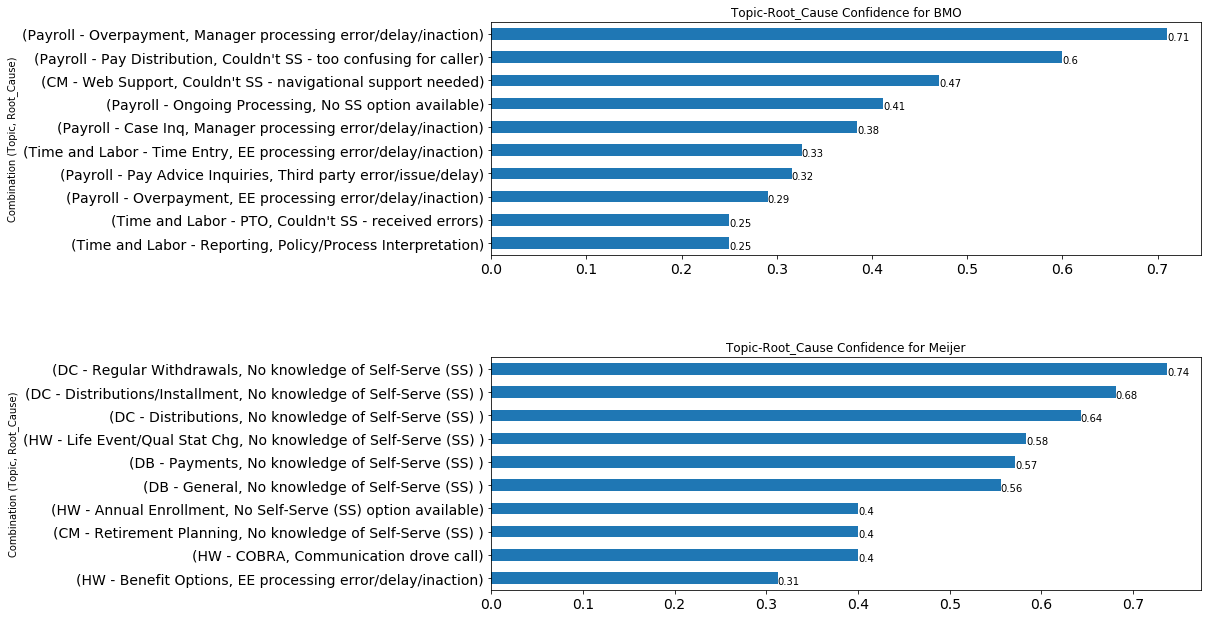

In [141]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.tight_layout(pad=2)

bmo_topic_asc.sort_values('Confidence',ascending=True,inplace=True)
meijer_topic_asc.sort_values('Confidence',ascending=True,inplace=True)

df_grp1 = bmo_topic_asc[['Combination (Topic, Root_Cause)','Confidence']].set_index('Combination (Topic, Root_Cause)').iloc[-10:]
df_grp2 = meijer_topic_asc[['Combination (Topic, Root_Cause)','Confidence']].set_index('Combination (Topic, Root_Cause)').iloc[-10:]

ax1 = df_grp1.plot.barh(ylim=0,ax=axes[0],figsize=(20,10),title="Topic-Root_Cause Confidence for BMO",fontsize=14,legend=False)
ax2 = df_grp2.plot.barh(ylim=0,ax=axes[1],figsize=(12,10),title="Topic-Root_Cause Confidence for Meijer",fontsize=14,legend=False)

for index,row in df_grp1.reset_index().iterrows():
    ax1.text(x=row["Confidence"], y=index-0.25, s=str(round(row["Confidence"],2)), fontsize=10)

for index,row in df_grp2.reset_index().iterrows():
    ax2.text(x=row["Confidence"], y=index-0.25, s=str(round(row["Confidence"],2)), fontsize=10)
print('\t\t\t\tDisplaying only Top 10 Most Associated Topic-Root Cause Combinations')
plt.show()

In [122]:
rc_meijer.columns

Index(['Universal_ID', 'cspro_notes', 'Cspro_Primary_Topic',
       'Cspro_Primary_Subtopic', 'Root_Cause'],
      dtype='object')

## Finding associations between Primary Sub Topic & Root Cause

In [131]:
bmo_subtopic_asc = Association_df(rc_bmo,groupby_cols=['Cspro_Primary_Subtopic'])
meijer_subtopic_asc = Association_df(rc_meijer,groupby_cols=['Cspro_Primary_Subtopic'])

In [133]:
bmo_subtopic_asc['Combination (SubTopic, Root_Cause)'] = bmo_subtopic_asc.apply(lambda x:(x.Cspro_Primary_Subtopic,x.Root_Cause), axis=1)
meijer_subtopic_asc['Combination (SubTopic, Root_Cause)'] = meijer_subtopic_asc.apply(lambda x:(x.Cspro_Primary_Subtopic,x.Root_Cause), axis=1)

				Displaying only Top 10 Most Frequent SubTopic-Root Cause Combinations


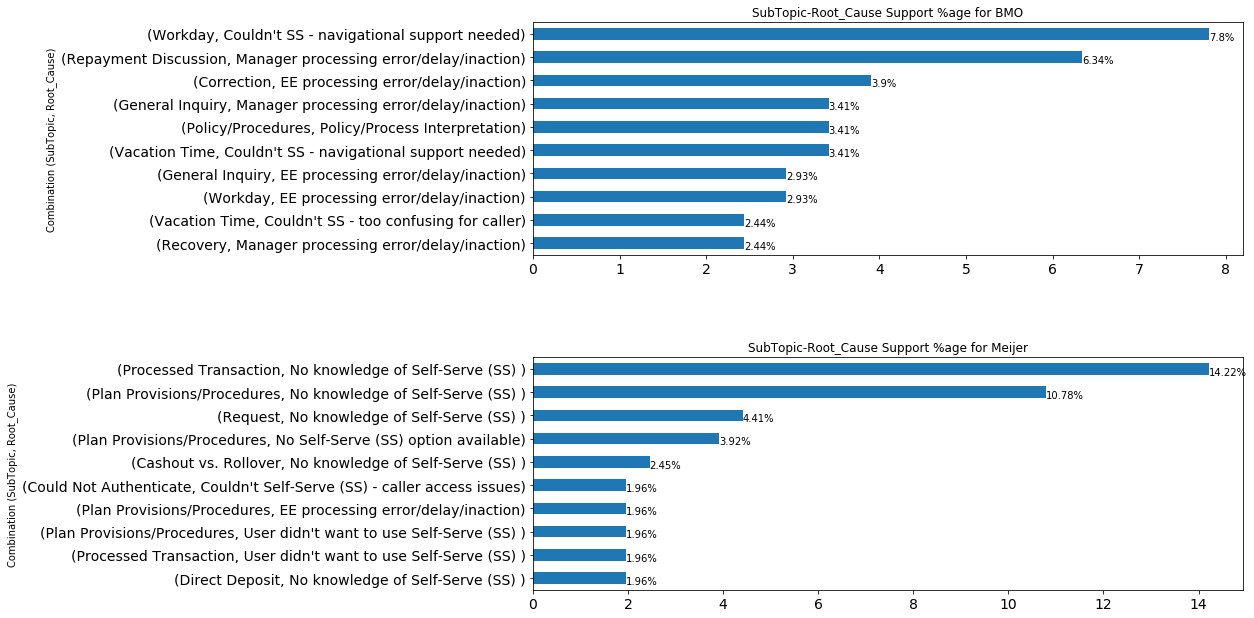

In [135]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.tight_layout(pad=2)
bmo_subtopic_asc.sort_values('support_combination',ascending=True,inplace=True)
meijer_subtopic_asc.sort_values('support_combination',ascending=True,inplace=True)
df_grp1 = bmo_subtopic_asc[['Combination (SubTopic, Root_Cause)','support_combination']].set_index('Combination (SubTopic, Root_Cause)').iloc[-10:]
df_grp2 = meijer_subtopic_asc[['Combination (SubTopic, Root_Cause)','support_combination']].set_index('Combination (SubTopic, Root_Cause)').iloc[-10:]

ax1 = df_grp1.plot.barh(ylim=0,ax=axes[0],figsize=(20,10),title="SubTopic-Root_Cause Support %age for BMO",fontsize=14,legend=False)
ax2 = df_grp2.plot.barh(ylim=0,ax=axes[1],figsize=(12,10),title="SubTopic-Root_Cause Support %age for Meijer",fontsize=14,legend=False)

for index,row in df_grp1.reset_index().iterrows():
    ax1.text(x=row["support_combination"], y=index-0.25, s=str(round(row["support_combination"],2))+"%", fontsize=10)

for index,row in df_grp2.reset_index().iterrows():
    ax2.text(x=row["support_combination"], y=index-0.25, s=str(round(row["support_combination"],2))+"%", fontsize=10)
print('\t\t\t\tDisplaying only Top 10 Most Frequent SubTopic-Root Cause Combinations')
plt.show()

				Displaying only Top 10 Most Associated SubTopic-Root Cause Combinations


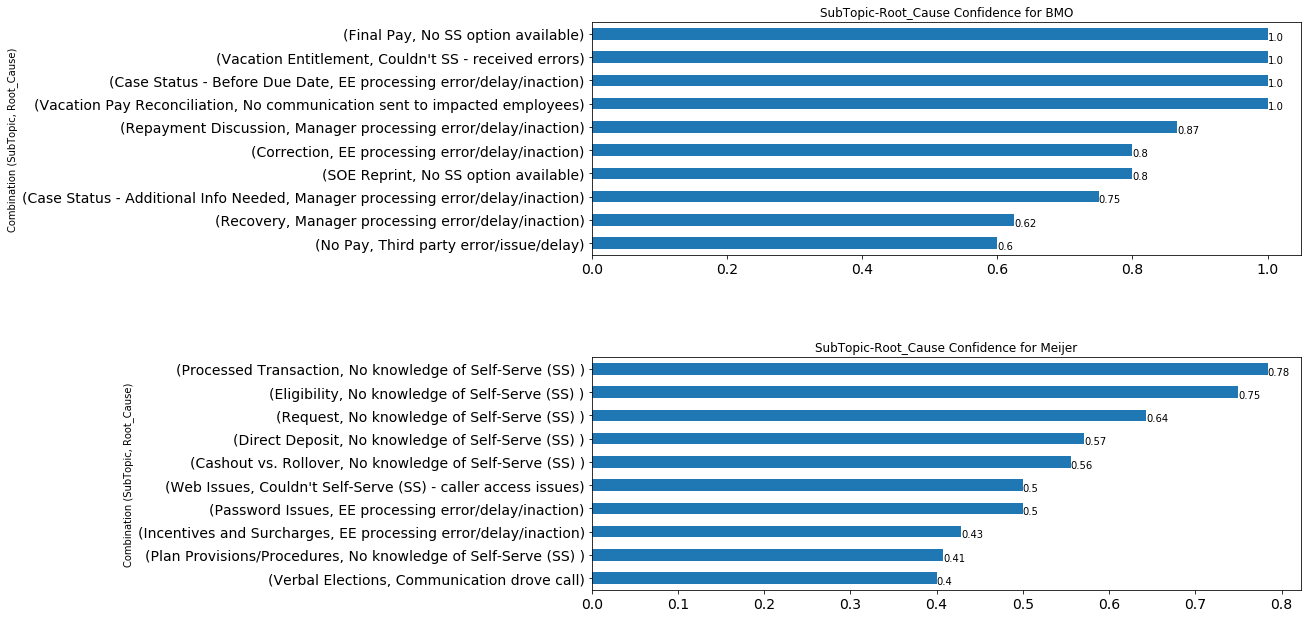

In [139]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.tight_layout(pad=2)

bmo_subtopic_asc.sort_values('Confidence',ascending=True,inplace=True)
meijer_subtopic_asc.sort_values('Confidence',ascending=True,inplace=True)

df_grp1 = bmo_subtopic_asc[['Combination (SubTopic, Root_Cause)','Confidence']].set_index('Combination (SubTopic, Root_Cause)').iloc[-10:]
df_grp2 = meijer_subtopic_asc[['Combination (SubTopic, Root_Cause)','Confidence']].set_index('Combination (SubTopic, Root_Cause)').iloc[-10:]

ax1 = df_grp1.plot.barh(ylim=0,ax=axes[0],figsize=(20,10),title="SubTopic-Root_Cause Confidence for BMO",fontsize=14,legend=False)
ax2 = df_grp2.plot.barh(ylim=0,ax=axes[1],figsize=(12,10),title="SubTopic-Root_Cause Confidence for Meijer",fontsize=14,legend=False)

for index,row in df_grp1.reset_index().iterrows():
    ax1.text(x=row["Confidence"], y=index-0.25, s=str(round(row["Confidence"],2)), fontsize=10)

for index,row in df_grp2.reset_index().iterrows():
    ax2.text(x=row["Confidence"], y=index-0.25, s=str(round(row["Confidence"],2)), fontsize=10)
print('\t\t\t\tDisplaying only Top 10 Most Associated SubTopic-Root Cause Combinations')
plt.show()

## Finding Associations between Topic, SubTopic & Root_Cause

In [142]:
rc_bmo.columns

Index(['Cspro_Primary_Subtopic', 'Cspro_Primary_Topic',
       'cspro_primary_topic_2', 'cspro_primary_subtopic_2', 'Root_Cause',
       'Universal_ID'],
      dtype='object')

In [145]:
bmo_asc = Association_df(rc_bmo,groupby_cols=['Cspro_Primary_Topic',"Cspro_Primary_Subtopic"])
meijer_asc = Association_df(rc_meijer,groupby_cols=['Cspro_Primary_Topic', 'Cspro_Primary_Subtopic'])

bmo_asc['Combination (Topic-SubTopic, Root_Cause)'] = bmo_asc.apply(lambda x:(x.Cspro_Primary_Topic
                                                                                          +": "+x.Cspro_Primary_Subtopic,
                                                                                          x.Root_Cause), axis=1)
meijer_asc['Combination (Topic-SubTopic, Root_Cause)'] = meijer_asc.apply(lambda x:(x.Cspro_Primary_Topic
                                                                                          +": "+x.Cspro_Primary_Subtopic,
                                                                                          x.Root_Cause), axis=1)

				Displaying only Top 10 Most Frequent Topic-Root Cause Combinations


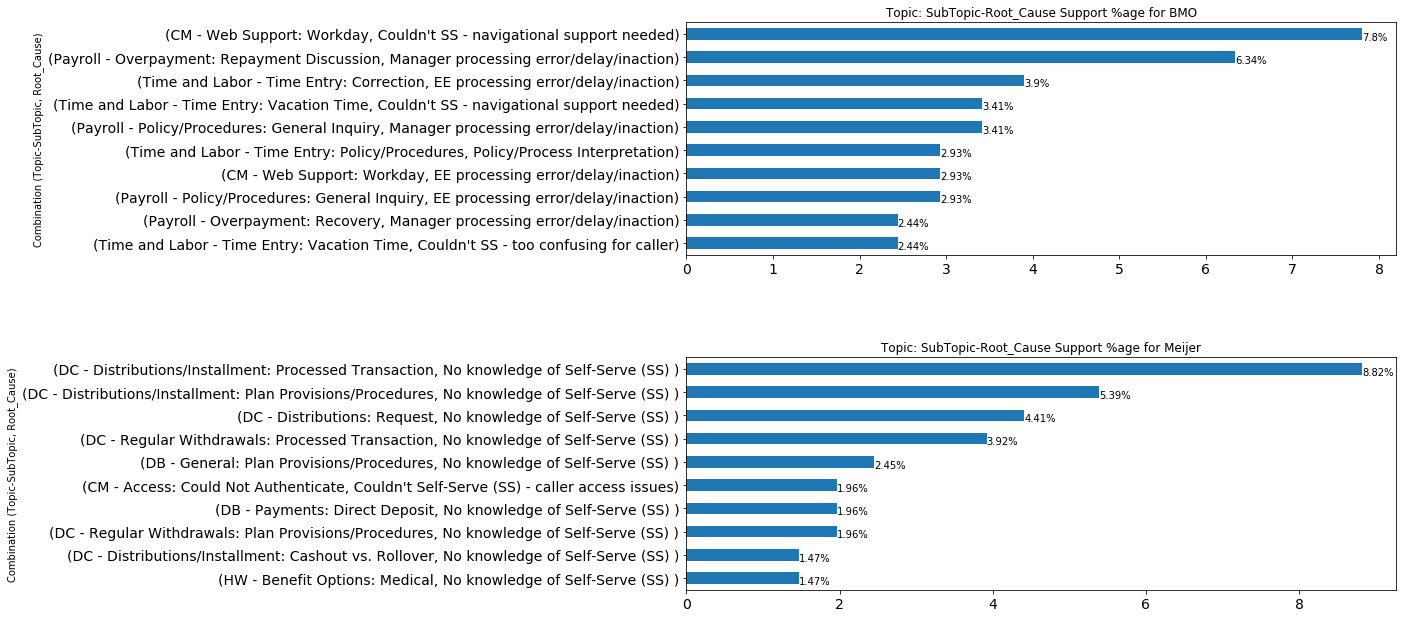

In [146]:
                                                                                        
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.tight_layout(pad=2)
bmo_asc.sort_values('support_combination',ascending=True,inplace=True)
meijer_asc.sort_values('support_combination',ascending=True,inplace=True)
df_grp1 = bmo_asc[['Combination (Topic-SubTopic, Root_Cause)','support_combination']].set_index('Combination (Topic-SubTopic, Root_Cause)').iloc[-10:]
df_grp2 = meijer_asc[['Combination (Topic-SubTopic, Root_Cause)','support_combination']].set_index('Combination (Topic-SubTopic, Root_Cause)').iloc[-10:]

ax1 = df_grp1.plot.barh(ylim=0,ax=axes[0],figsize=(20,10),title="Topic: SubTopic-Root_Cause Support %age for BMO",fontsize=14,legend=False)
ax2 = df_grp2.plot.barh(ylim=0,ax=axes[1],figsize=(12,10),title="Topic: SubTopic-Root_Cause Support %age for Meijer",fontsize=14,legend=False)

for index,row in df_grp1.reset_index().iterrows():
    ax1.text(x=row["support_combination"], y=index-0.25, s=str(round(row["support_combination"],2))+"%", fontsize=10)

for index,row in df_grp2.reset_index().iterrows():
    ax2.text(x=row["support_combination"], y=index-0.25, s=str(round(row["support_combination"],2))+"%", fontsize=10)
print('\t\t\t\tDisplaying only Top 10 Most Frequent Topic-Root Cause Combinations')
plt.show()

				Displaying only Top 10 Most Associated Topic-Root Cause Combinations


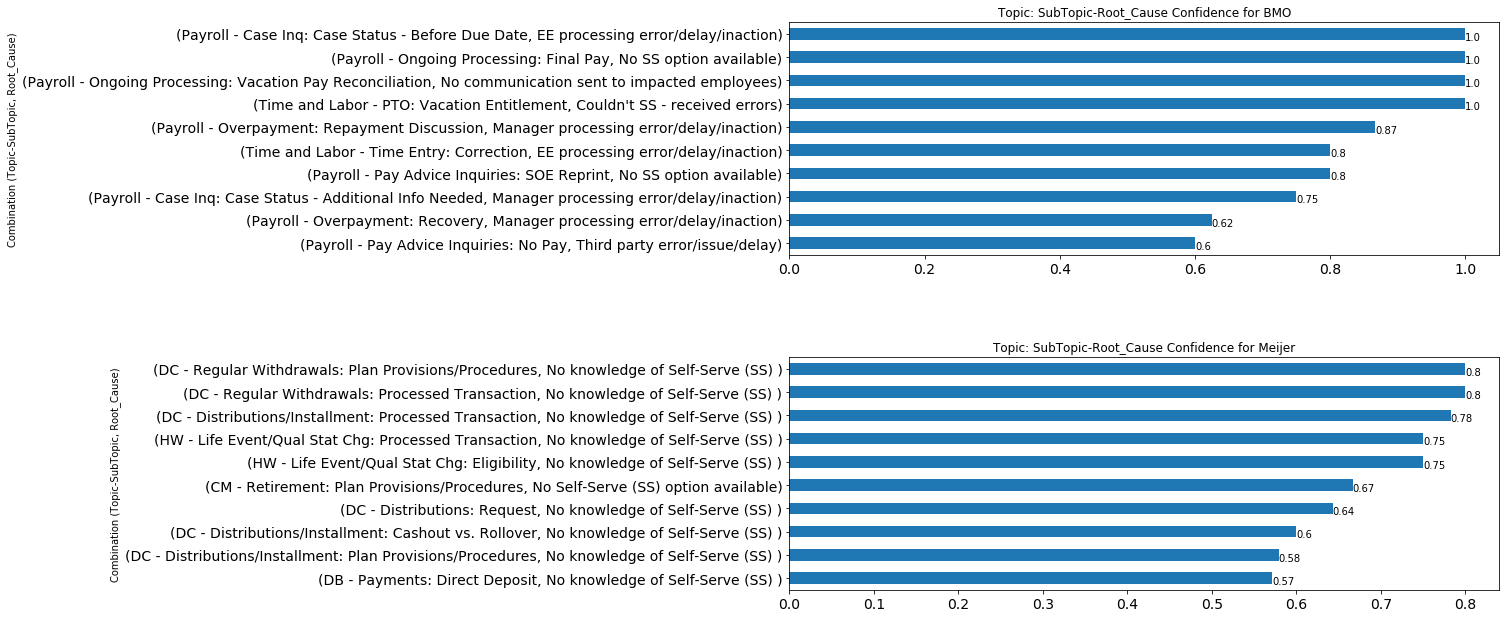

In [147]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.tight_layout(pad=2)

bmo_asc.sort_values('Confidence',ascending=True,inplace=True)
meijer_asc.sort_values('Confidence',ascending=True,inplace=True)

df_grp1 = bmo_asc[['Combination (Topic-SubTopic, Root_Cause)','Confidence']].set_index('Combination (Topic-SubTopic, Root_Cause)').iloc[-10:]
df_grp2 = meijer_asc[['Combination (Topic-SubTopic, Root_Cause)','Confidence']].set_index('Combination (Topic-SubTopic, Root_Cause)').iloc[-10:]

ax1 = df_grp1.plot.barh(ylim=0,ax=axes[0],figsize=(20,10),title="Topic: SubTopic-Root_Cause Confidence for BMO",fontsize=14,legend=False)
ax2 = df_grp2.plot.barh(ylim=0,ax=axes[1],figsize=(12,10),title="Topic: SubTopic-Root_Cause Confidence for Meijer",fontsize=14,legend=False)

for index,row in df_grp1.reset_index().iterrows():
    ax1.text(x=row["Confidence"], y=index-0.25, s=str(round(row["Confidence"],2)), fontsize=10)

for index,row in df_grp2.reset_index().iterrows():
    ax2.text(x=row["Confidence"], y=index-0.25, s=str(round(row["Confidence"],2)), fontsize=10)
print('\t\t\t\tDisplaying only Top 10 Most Associated Topic-Root Cause Combinations')
plt.show()